# P9: Triangulation 



This notebook demonstrates triangulation using two images captured from slightly different positions. We will:
1. Detect and match keypoints using multiple feature detectors (ORB, SIFT, AKAZE)
2. Calculate 3D coordinates using triangulation (OpenCV SFM pipeline)
3. Display matched keypoints and visualize 3D coordinates



## 1. Import Libraries and Load Images

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Check OpenCV version
print(f"OpenCV Version: {cv2.__version__}")

# Check available feature detectors
print("\nAvailable Feature Detectors:")
print("ORB  - Oriented FAST and Rotated BRIEF (Fast, Binary)")
print("SIFT - Scale-Invariant Feature Transform (Robust, Float)")
print("AKAZE - Accelerated-KAZE (Scale-invariant, Open-source alternative to SURF)")

OpenCV Version: 4.10.0

Available Feature Detectors:
✓ ORB  - Oriented FAST and Rotated BRIEF (Fast, Binary)
✓ SIFT - Scale-Invariant Feature Transform (Robust, Float)
✓ AKAZE - Accelerated-KAZE (Scale-invariant, Open-source alternative to SURF)


Left Image shape: (730, 732, 3)
Right Image shape: (756, 757, 3)


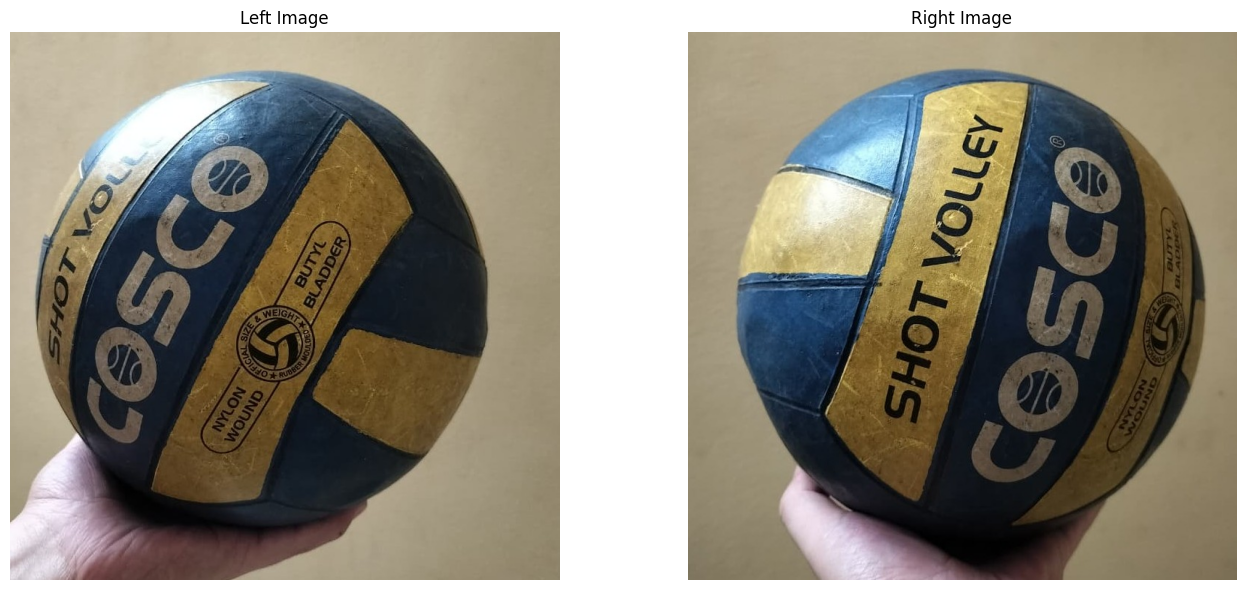

In [33]:
# Load left and right images
img_left = cv2.imread('left.jpeg')
img_right = cv2.imread('right.jpeg')

if img_left is None or img_right is None:
    raise FileNotFoundError("Could not load 'left.jpeg' or 'right.jpeg'. Please ensure the images are in the same directory.")

# Convert to RGB for display
img_left_rgb = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
img_right_rgb = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)

# Convert to grayscale for feature detection
gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

print(f"Left Image shape: {img_left.shape}")
print(f"Right Image shape: {img_right.shape}")

# Display images
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(img_left_rgb)
axes[0].set_title('Left Image')
axes[0].axis('off')
axes[1].imshow(img_right_rgb)
axes[1].set_title('Right Image')
axes[1].axis('off')
plt.tight_layout()
plt.show()

## 2. Feature Detection and Matching

We'll implement feature detection using three different detectors:
1. **ORB (Oriented FAST and Rotated BRIEF)** - Open source, fast, binary descriptor
2. **SIFT (Scale-Invariant Feature Transform)** - Robust but slower, available in OpenCV 4.4+
3. **AKAZE (Accelerated-KAZE)** - Open-source alternative to SURF, scale-invariant, nonlinear scale space

### 2.1 ORB Feature Detection (Open Source)

ORB: Found 500 keypoints in left image
ORB: Found 500 keypoints in right image
ORB: Found 125 matches


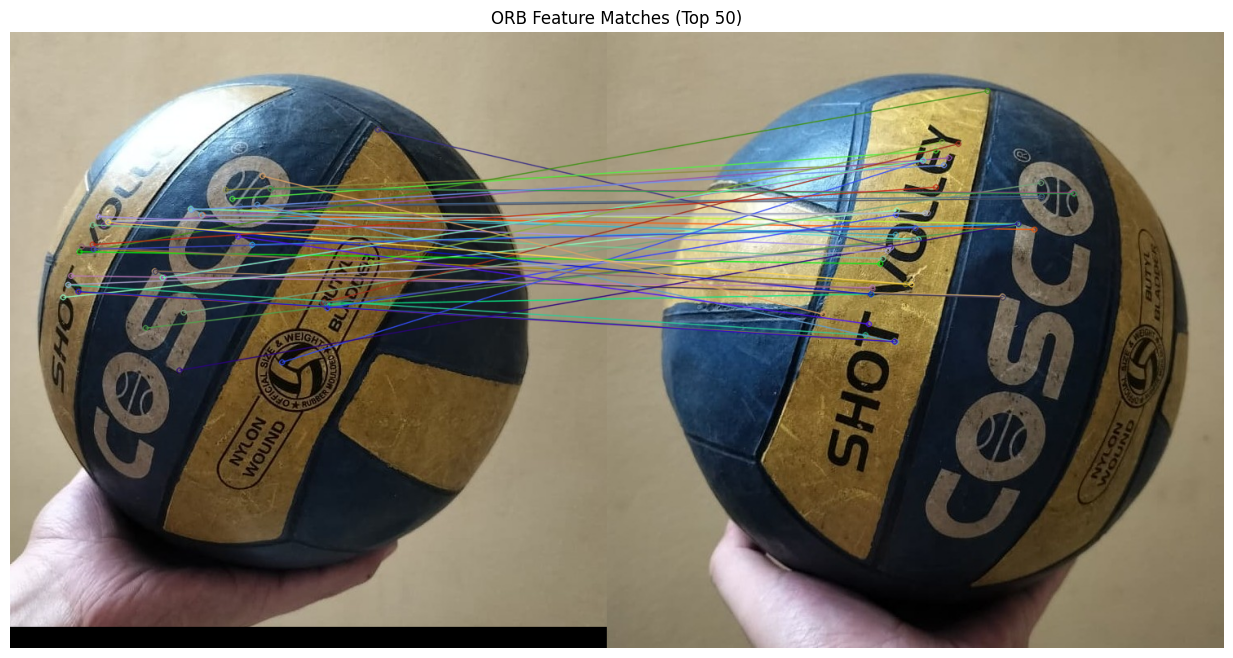

In [34]:
def detect_and_match_orb(gray1, gray2, n_features=500):
    """
    Detect and match features using ORB detector.
    ORB uses binary descriptors -> use Hamming distance for matching.
    """
    # Create ORB detector
    orb = cv2.ORB_create(nfeatures=n_features)
    
    # Detect keypoints and compute descriptors
    kp1, des1 = orb.detectAndCompute(gray1, None)
    kp2, des2 = orb.detectAndCompute(gray2, None)
    
    print(f"ORB: Found {len(kp1)} keypoints in left image")
    print(f"ORB: Found {len(kp2)} keypoints in right image")
    
    if des1 is None or des2 is None:
        return None, None, None
    
    # Match using BFMatcher with Hamming distance
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    
    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)
    
    print(f"ORB: Found {len(matches)} matches")
    
    return kp1, kp2, matches

# Detect and match using ORB
kp1_orb, kp2_orb, matches_orb = detect_and_match_orb(gray_left, gray_right)

# Visualize matches
good_matches_orb = matches_orb[:50]  # Top 50 matches
img_matches_orb = cv2.drawMatches(img_left, kp1_orb, img_right, kp2_orb, good_matches_orb, None,
                                   flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(16, 8))
plt.imshow(cv2.cvtColor(img_matches_orb, cv2.COLOR_BGR2RGB))
plt.title('ORB Feature Matches (Top 50)')
plt.axis('off')
plt.show()

### 2.2 SIFT Feature Detection

SIFT: Found 1969 keypoints in left image
SIFT: Found 1814 keypoints in right image
SIFT: Found 150 good matches after ratio test


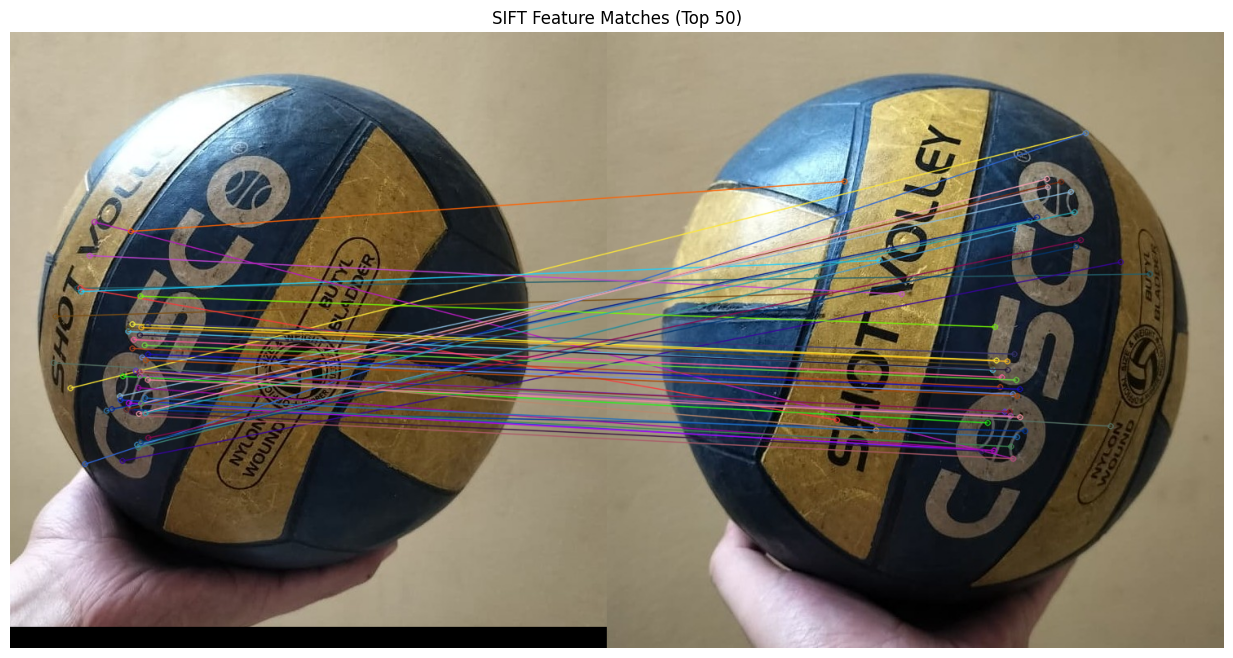

In [35]:
def detect_and_match_sift(gray1, gray2, ratio_thresh=0.75):
    """
    Detect and match features using SIFT detector.
    SIFT uses floating-point descriptors -> use L2 distance for matching.
    Lowe's ratio test is applied for better match quality.
    """
    # Create SIFT detector
    sift = cv2.SIFT_create()
    
    # Detect keypoints and compute descriptors
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)
    
    print(f"SIFT: Found {len(kp1)} keypoints in left image")
    print(f"SIFT: Found {len(kp2)} keypoints in right image")
    
    if des1 is None or des2 is None:
        return None, None, None
    
    # Match using FLANN (Fast Library for Approximate Nearest Neighbors)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    matches = flann.knnMatch(des1, des2, k=2)
    
    # Apply Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    
    print(f"SIFT: Found {len(good_matches)} good matches after ratio test")
    
    return kp1, kp2, good_matches

# Detect and match using SIFT
kp1_sift, kp2_sift, matches_sift = detect_and_match_sift(gray_left, gray_right)

if matches_sift is not None:
    # Visualize matches
    good_matches_sift = matches_sift[:50]  # Top 50 matches
    img_matches_sift = cv2.drawMatches(img_left, kp1_sift, img_right, kp2_sift, good_matches_sift, None,
                                        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    plt.figure(figsize=(16, 8))
    plt.imshow(cv2.cvtColor(img_matches_sift, cv2.COLOR_BGR2RGB))
    plt.title('SIFT Feature Matches (Top 50)')
    plt.axis('off')
    plt.show()

### 2.3 AKAZE Feature Detection 

**AKAZE** (Accelerated-KAZE) is a fully open-source alternative to SURF that provides:
- Scale and rotation invariance
- Nonlinear scale space (better edge preservation than SIFT/SURF)
- Binary descriptors (faster matching like ORB)
- Available in all OpenCV builds without patent restrictions

AKAZE: Found 729 keypoints in left image
AKAZE: Found 1053 keypoints in right image
AKAZE: Found 285 matches


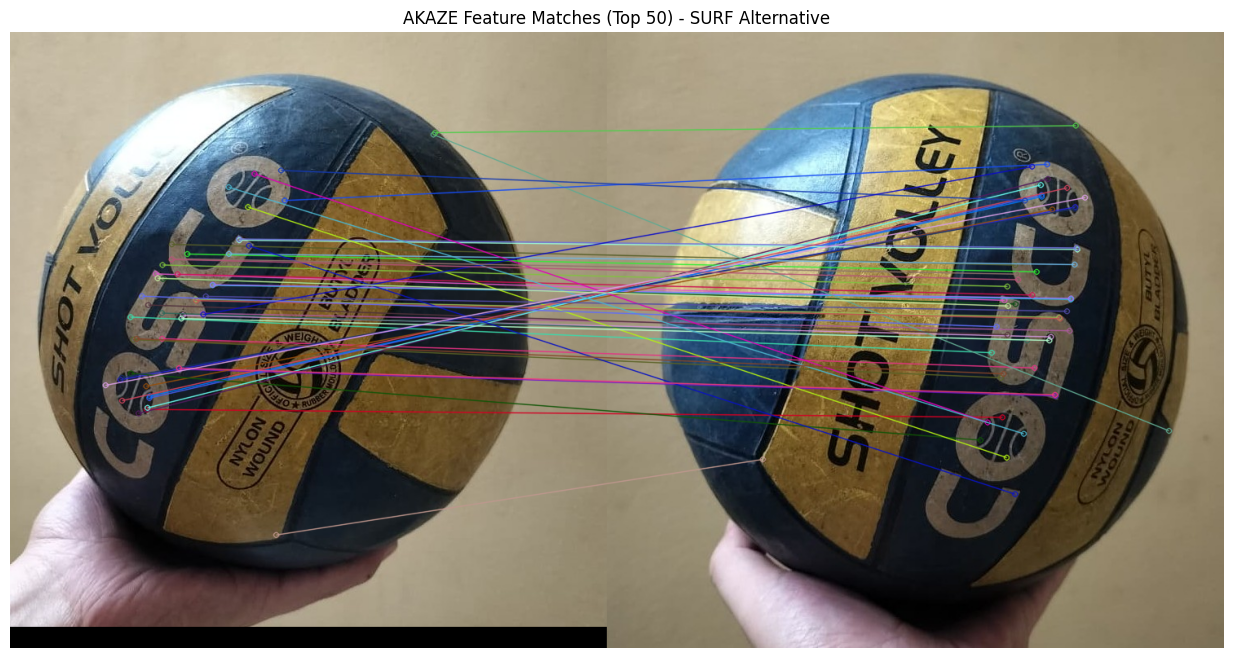

In [36]:
def detect_and_match_akaze(gray1, gray2):
    """
    Detect and match features using AKAZE detector.
    AKAZE is an open-source alternative to SURF with similar properties:
    - Scale invariant
    - Rotation invariant
    - Uses nonlinear scale space (preserves edges better)
    - Binary descriptors (fast matching)
    """
    # Create AKAZE detector
    akaze = cv2.AKAZE_create()
    
    # Detect keypoints and compute descriptors
    kp1, des1 = akaze.detectAndCompute(gray1, None)
    kp2, des2 = akaze.detectAndCompute(gray2, None)
    
    print(f"AKAZE: Found {len(kp1)} keypoints in left image")
    print(f"AKAZE: Found {len(kp2)} keypoints in right image")
    
    if des1 is None or des2 is None or len(des1) == 0 or len(des2) == 0:
        print("AKAZE: No descriptors found.")
        return None, None, None
    
    # Match using BFMatcher with Hamming distance (binary descriptors)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    
    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)
    
    print(f"AKAZE: Found {len(matches)} matches")
    
    return kp1, kp2, matches

# Detect and match using AKAZE
kp1_akaze, kp2_akaze, matches_akaze = detect_and_match_akaze(gray_left, gray_right)

if matches_akaze is not None and len(matches_akaze) > 0:
    # Visualize matches
    good_matches_akaze = matches_akaze[:50]  # Top 50 matches
    img_matches_akaze = cv2.drawMatches(img_left, kp1_akaze, img_right, kp2_akaze, good_matches_akaze, None,
                                        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    plt.figure(figsize=(16, 8))
    plt.imshow(cv2.cvtColor(img_matches_akaze, cv2.COLOR_BGR2RGB))
    plt.title('AKAZE Feature Matches (Top 50) - SURF Alternative')
    plt.axis('off')
    plt.show()
else:
    print("AKAZE: No matches to visualize.")

## 3. Triangulation using OpenCV SFM Pipeline

The triangulation process follows these steps:
1. **Camera Calibration Matrix (K)**: Define intrinsic parameters
2. **Essential Matrix (E)**: Compute from matched points
3. **Pose Recovery**: Decompose E into rotation (R) and translation (t)
4. **Projection Matrices**: Construct P1 and P2
5. **Triangulation**: Compute 3D points from 2D correspondences

Reference: [OpenCV SFM Tutorial](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html)

In [37]:
def triangulate_points(kp1, kp2, matches, img_shape, min_matches=8):
    """
    Triangulate 3D points from matched 2D keypoints.
    
    Parameters:
    - kp1, kp2: Keypoints from left and right images
    - matches: Matched keypoint indices
    - img_shape: Shape of the image (height, width)
    - min_matches: Minimum number of matches required
    
    Returns:
    - points3D: Nx3 array of 3D coordinates
    - pts1, pts2: Matched 2D points
    - R, t: Rotation and translation
    """
    if matches is None or len(matches) < min_matches:
        print(f"Not enough matches ({len(matches) if matches else 0}) for triangulation. Need at least {min_matches}.")
        return None, None, None, None, None
    
    # Extract matched point coordinates
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    
    # Camera Intrinsic Matrix (assuming uncalibrated camera)
    h, w = img_shape[:2]
    f = w  # Approximate focal length as image width
    K = np.array([[f, 0, w/2],
                  [0, f, h/2],
                  [0, 0, 1]], dtype=np.float64)
    
    print(f"Camera Matrix K:\n{K}\n")
    
    # Step 1: Find Essential Matrix
    E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    
    print(f"Essential Matrix E:\n{E}\n")
    
    # Filter inliers
    pts1_inliers = pts1[mask.ravel() == 1]
    pts2_inliers = pts2[mask.ravel() == 1]
    
    print(f"Inliers after RANSAC: {len(pts1_inliers)} / {len(pts1)}")
    
    if len(pts1_inliers) < min_matches:
        print(f"Not enough inliers for pose recovery.")
        return None, None, None, None, None
    
    # Step 2: Recover Pose (R and t)
    _, R, t, mask_pose = cv2.recoverPose(E, pts1_inliers, pts2_inliers, K)
    
    print(f"\nRotation Matrix R:\n{R}")
    print(f"\nTranslation Vector t:\n{t.T}\n")
    
    # Filter by pose mask
    pts1_final = pts1_inliers[mask_pose.ravel() > 0]
    pts2_final = pts2_inliers[mask_pose.ravel() > 0]
    
    print(f"Points after pose recovery: {len(pts1_final)}")
    
    if len(pts1_final) < 4:
        print("Not enough points for triangulation.")
        return None, None, None, None, None
    
    # Step 3: Construct Projection Matrices
    # P1 = K * [I | 0] (camera at origin)
    P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
    
    # P2 = K * [R | t] (second camera position)
    P2 = K @ np.hstack((R, t))
    
    # Step 4: Triangulate Points
    # triangulatePoints expects 2xN arrays
    pts1_norm = pts1_final.T.astype(np.float64)
    pts2_norm = pts2_final.T.astype(np.float64)
    
    points4D = cv2.triangulatePoints(P1, P2, pts1_norm, pts2_norm)
    
    # Convert from homogeneous to 3D coordinates
    points3D = (points4D[:3] / points4D[3]).T
    
    return points3D, pts1_final, pts2_final, R, t

### 3.1 Triangulation with ORB Features

In [38]:
print("=" * 60)
print("TRIANGULATION USING ORB FEATURES")
print("=" * 60)

points3D_orb, pts1_orb, pts2_orb, R_orb, t_orb = triangulate_points(
    kp1_orb, kp2_orb, matches_orb, img_left.shape
)

if points3D_orb is not None:
    print("\n--- 3D Coordinates of Matched Points (ORB) ---")
    print(f"{'Point ID':<10} {'X':<15} {'Y':<15} {'Z':<15}")
    print("-" * 55)
    for i, pt in enumerate(points3D_orb[:20]):  # Display first 20 points
        print(f"{i:<10} {pt[0]:<15.4f} {pt[1]:<15.4f} {pt[2]:<15.4f}")
    if len(points3D_orb) > 20:
        print(f"... and {len(points3D_orb) - 20} more points")

TRIANGULATION USING ORB FEATURES
Camera Matrix K:
[[732.   0. 366.]
 [  0. 732. 365.]
 [  0.   0.   1.]]

Essential Matrix E:
[[ 0.53615137 -0.36833972  0.04402825]
 [-0.44407481 -0.52631437  0.00707713]
 [ 0.11949939 -0.29317934  0.02086855]]

Inliers after RANSAC: 18 / 125

Rotation Matrix R:
[[-0.54071709 -0.73903226  0.40181631]
 [-0.75348028  0.63788647  0.15927432]
 [-0.37402205 -0.21663832 -0.90176236]]

Translation Vector t:
[[-0.38711514 -0.22689495  0.8936781 ]]

Points after pose recovery: 16

--- 3D Coordinates of Matched Points (ORB) ---
Point ID   X               Y               Z              
-------------------------------------------------------
0          -0.1852         -0.0703         0.7187         
1          -0.1851         -0.0708         0.7176         
2          -0.1848         -0.0700         0.7194         
3          -0.2219         -0.0369         0.5758         
4          -0.2220         -0.0365         0.5764         
5          -0.1980         -0.075

### 3.2 Triangulation with SIFT Features

In [39]:
print("=" * 60)
print("TRIANGULATION USING SIFT FEATURES")
print("=" * 60)

points3D_sift = None
if matches_sift is not None:
    points3D_sift, pts1_sift_tri, pts2_sift_tri, R_sift, t_sift = triangulate_points(
        kp1_sift, kp2_sift, matches_sift, img_left.shape
    )
    
    if points3D_sift is not None:
        print("\n--- 3D Coordinates of Matched Points (SIFT) ---")
        print(f"{'Point ID':<10} {'X':<15} {'Y':<15} {'Z':<15}")
        print("-" * 55)
        for i, pt in enumerate(points3D_sift[:20]):
            print(f"{i:<10} {pt[0]:<15.4f} {pt[1]:<15.4f} {pt[2]:<15.4f}")
        if len(points3D_sift) > 20:
            print(f"... and {len(points3D_sift) - 20} more points")
else:
    print("SIFT features not available.")

TRIANGULATION USING SIFT FEATURES
Camera Matrix K:
[[732.   0. 366.]
 [  0. 732. 365.]
 [  0.   0.   1.]]

Essential Matrix E:
[[-0.0161609  -0.12143659 -0.0870913 ]
 [-0.22962635  0.02077806 -0.66299778]
 [-0.06801288  0.6922392   0.02932879]]

Inliers after RANSAC: 55 / 150

Rotation Matrix R:
[[ 0.850682    0.22687618 -0.47420179]
 [-0.20343892  0.97386627  0.1009807 ]
 [ 0.48471924  0.01056863  0.87460595]]

Translation Vector t:
[[ 0.97714593 -0.12061472  0.1750369 ]]

Points after pose recovery: 55

--- 3D Coordinates of Matched Points (SIFT) ---
Point ID   X               Y               Z              
-------------------------------------------------------
0          -0.3726         0.1387          1.1820         
1          -0.3614         0.0907          1.1607         
2          -0.3439         0.0034          1.1366         
3          -0.3431         -0.0041         1.1357         
4          -0.3535         0.1435          1.1724         
5          -0.3347         -0.0

### 3.3 Triangulation with AKAZE Features

In [40]:
print("=" * 60)
print("TRIANGULATION USING AKAZE FEATURES")
print("=" * 60)

points3D_akaze = None
if matches_akaze is not None and len(matches_akaze) > 0:
    points3D_akaze, pts1_akaze_tri, pts2_akaze_tri, R_akaze, t_akaze = triangulate_points(
        kp1_akaze, kp2_akaze, matches_akaze, img_left.shape
    )
    
    if points3D_akaze is not None:
        print("\n--- 3D Coordinates of Matched Points (AKAZE) ---")
        print(f"{'Point ID':<10} {'X':<15} {'Y':<15} {'Z':<15}")
        print("-" * 55)
        for i, pt in enumerate(points3D_akaze[:20]):
            print(f"{i:<10} {pt[0]:<15.4f} {pt[1]:<15.4f} {pt[2]:<15.4f}")
        if len(points3D_akaze) > 20:
            print(f"... and {len(points3D_akaze) - 20} more points")
else:
    print("AKAZE features not available.")

TRIANGULATION USING AKAZE FEATURES
Camera Matrix K:
[[732.   0. 366.]
 [  0. 732. 365.]
 [  0.   0.   1.]]

Essential Matrix E:
[[-0.08328878  0.63274054 -0.09818158]
 [-0.48645563 -0.08673089 -0.49190952]
 [ 0.05240826  0.30331958  0.0466591 ]]

Inliers after RANSAC: 38 / 285

Rotation Matrix R:
[[ 0.92034215  0.1753907   0.34958322]
 [-0.19415512  0.98078535  0.0190756 ]
 [-0.33952042 -0.08542945  0.9367111 ]]

Translation Vector t:
[[ 0.407585   -0.16651545 -0.89785693]]

Points after pose recovery: 33

--- 3D Coordinates of Matched Points (AKAZE) ---
Point ID   X               Y               Z              
-------------------------------------------------------
0          -1.9371         -0.7084         7.5568         
1          -1.2008         -0.5558         7.4599         
2          -1.3900         -0.1618         6.5865         
3          -1.3097         -0.3530         6.9218         
4          -1.7676         -0.6127         7.2343         
5          -1.1990         -0

## 4. 3D Point Cloud Visualization

Visualizing 16 / 16 valid points


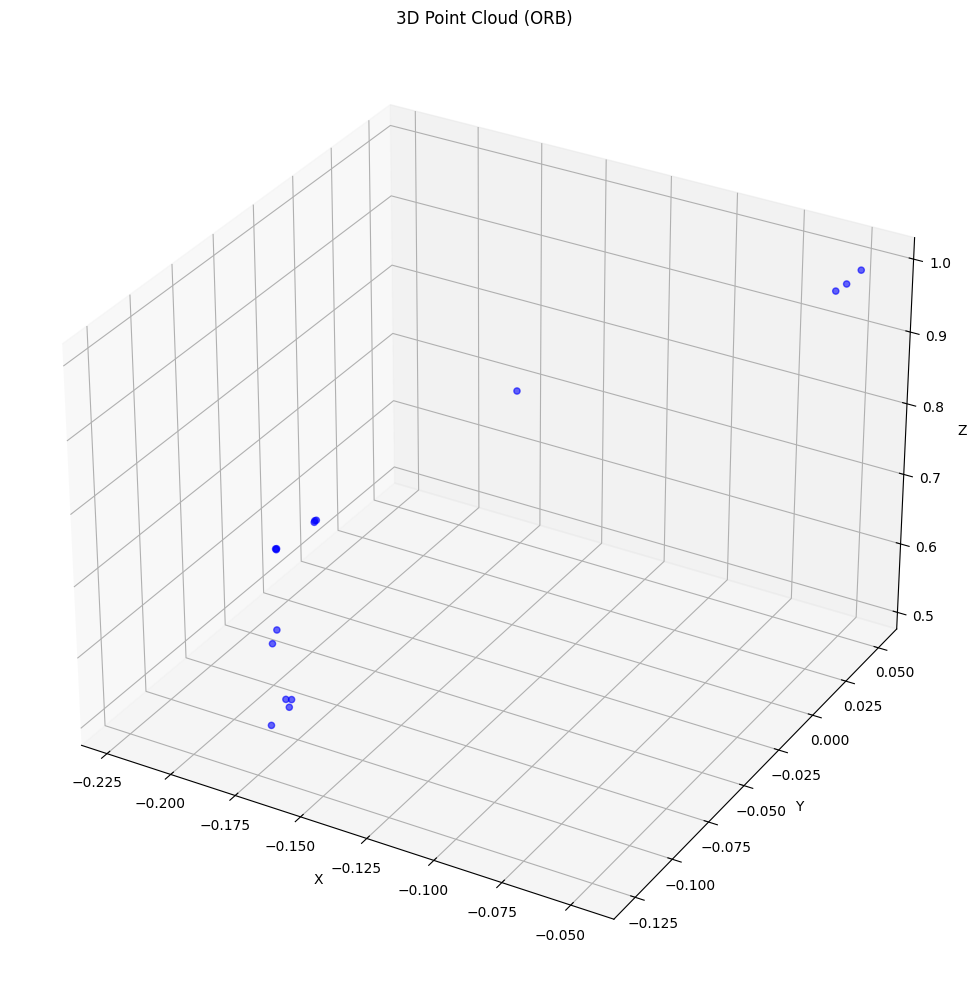

In [41]:
def visualize_3d_points(points3D, title="3D Point Cloud", color='b'):
    """
    Visualize 3D points using matplotlib.
    """
    if points3D is None or len(points3D) == 0:
        print("No 3D points to visualize.")
        return
    
    # Filter out points at infinity or very far
    valid_mask = np.all(np.abs(points3D) < 1000, axis=1)
    points_filtered = points3D[valid_mask]
    
    print(f"Visualizing {len(points_filtered)} / {len(points3D)} valid points")
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(points_filtered[:, 0], 
               points_filtered[:, 1], 
               points_filtered[:, 2], 
               c=color, marker='o', s=20, alpha=0.6)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    
    plt.tight_layout()
    plt.show()

# Visualize ORB 3D points
if points3D_orb is not None:
    visualize_3d_points(points3D_orb, "3D Point Cloud (ORB)", 'blue')

Visualizing 55 / 55 valid points


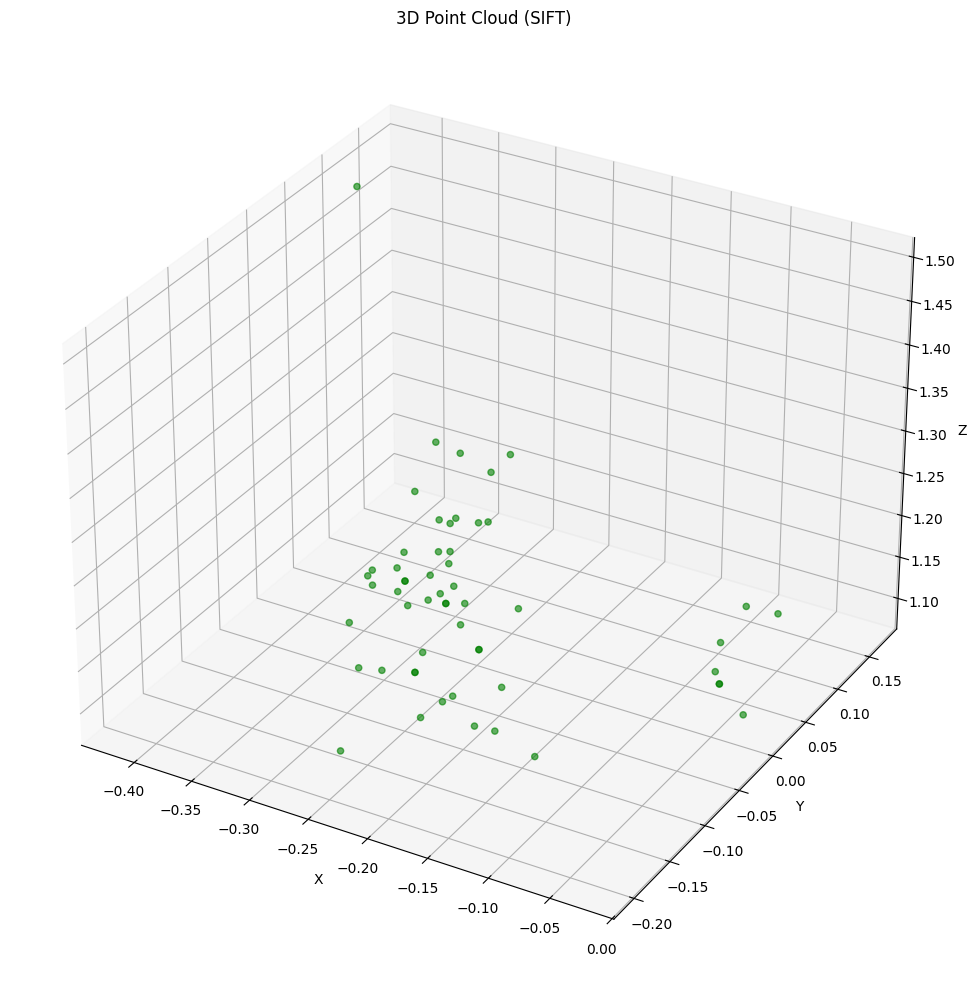

In [42]:
# Visualize SIFT 3D points
if points3D_sift is not None:
    visualize_3d_points(points3D_sift, "3D Point Cloud (SIFT)", 'green')

Visualizing 33 / 33 valid points


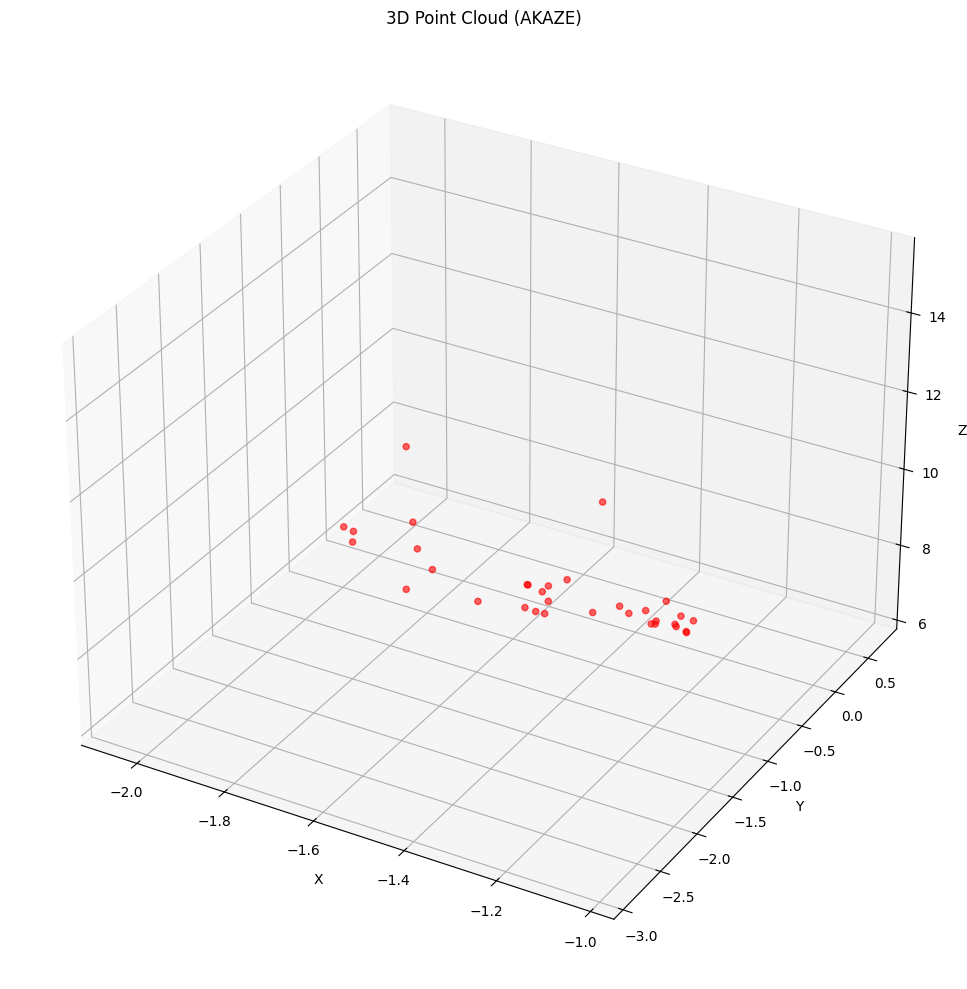

In [43]:
# Visualize AKAZE 3D points
if points3D_akaze is not None:
    visualize_3d_points(points3D_akaze, "3D Point Cloud (AKAZE)", 'red')

## 5. Comparison of Feature Detectors

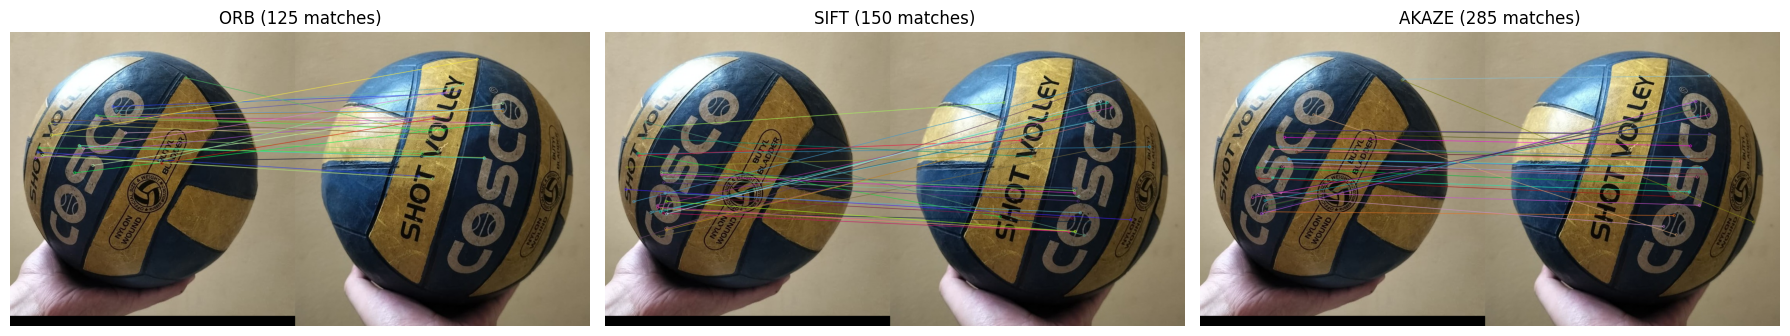

In [44]:
# Compare all three detectors side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# ORB
if matches_orb is not None:
    img_orb = cv2.drawMatches(img_left, kp1_orb, img_right, kp2_orb, matches_orb[:30], None,
                               flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    axes[0].imshow(cv2.cvtColor(img_orb, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f'ORB ({len(matches_orb)} matches)')
    axes[0].axis('off')

# SIFT
if matches_sift is not None:
    img_sift = cv2.drawMatches(img_left, kp1_sift, img_right, kp2_sift, matches_sift[:30], None,
                                flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    axes[1].imshow(cv2.cvtColor(img_sift, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'SIFT ({len(matches_sift)} matches)')
else:
    axes[1].text(0.5, 0.5, 'SIFT Not Available', ha='center', va='center', fontsize=14)
axes[1].axis('off')

# AKAZE
if matches_akaze is not None and len(matches_akaze) > 0:
    img_akaze = cv2.drawMatches(img_left, kp1_akaze, img_right, kp2_akaze, matches_akaze[:30], None,
                                flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    axes[2].imshow(cv2.cvtColor(img_akaze, cv2.COLOR_BGR2RGB))
    axes[2].set_title(f'AKAZE ({len(matches_akaze)} matches)')
else:
    axes[2].text(0.5, 0.5, 'AKAZE - No matches found', 
                 ha='center', va='center', fontsize=12)
axes[2].axis('off')

plt.tight_layout()
plt.savefig('feature_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [45]:
# Summary statistics
print("\n" + "=" * 60)
print("FEATURE DETECTOR COMPARISON SUMMARY")
print("=" * 60)
print(f"{'Detector':<15} {'Keypoints':<20} {'Matches':<15} {'3D Points':<15}")
print("-" * 65)

# ORB
orb_kp = f"{len(kp1_orb)} / {len(kp2_orb)}" if kp1_orb else "N/A"
orb_matches = len(matches_orb) if matches_orb else "N/A"
orb_3d = len(points3D_orb) if points3D_orb is not None else "N/A"
print(f"{'ORB':<15} {orb_kp:<20} {orb_matches:<15} {orb_3d:<15}")

# SIFT
sift_kp = f"{len(kp1_sift)} / {len(kp2_sift)}" if kp1_sift else "N/A"
sift_matches = len(matches_sift) if matches_sift else "N/A"
sift_3d = len(points3D_sift) if points3D_sift is not None else "N/A"
print(f"{'SIFT':<15} {sift_kp:<20} {sift_matches:<15} {sift_3d:<15}")

# AKAZE
akaze_kp = f"{len(kp1_akaze)} / {len(kp2_akaze)}" if kp1_akaze else "N/A"
akaze_matches = len(matches_akaze) if matches_akaze else "N/A"
akaze_3d = len(points3D_akaze) if points3D_akaze is not None else "N/A"
print(f"{'AKAZE':<15} {akaze_kp:<20} {akaze_matches:<15} {akaze_3d:<15}")


FEATURE DETECTOR COMPARISON SUMMARY
Detector        Keypoints            Matches         3D Points      
-----------------------------------------------------------------
ORB             500 / 500            125             16             
SIFT            1969 / 1814          150             55             
AKAZE           729 / 1053           285             33             


## 6. Save Results

In [46]:
# Save the ORB matches visualization
if matches_orb is not None:
    cv2.imwrite('orb_matches.jpg', img_matches_orb)
    print("Saved: orb_matches.jpg")

# Save 3D coordinates to CSV
if points3D_orb is not None:
    np.savetxt('3d_coordinates_orb.csv', points3D_orb, delimiter=',', 
               header='X,Y,Z', comments='', fmt='%.6f')
    print("Saved: 3d_coordinates_orb.csv")

if points3D_sift is not None:
    np.savetxt('3d_coordinates_sift.csv', points3D_sift, delimiter=',', 
               header='X,Y,Z', comments='', fmt='%.6f')
    print("Saved: 3d_coordinates_sift.csv")

if points3D_akaze is not None:
    np.savetxt('3d_coordinates_akaze.csv', points3D_akaze, delimiter=',', 
               header='X,Y,Z', comments='', fmt='%.6f')
    print("Saved: 3d_coordinates_akaze.csv")

print("\nAll results saved successfully!")

Saved: orb_matches.jpg
Saved: 3d_coordinates_orb.csv
Saved: 3d_coordinates_sift.csv
Saved: 3d_coordinates_akaze.csv

All results saved successfully!


## 7. Observations and Conclusions

### Feature Detector Comparison:

| Feature | ORB | SIFT | AKAZE |
|---------|-----|------|-------|
| **Speed** | Fast | Slow | Medium |
| **Descriptor Type** | Binary | Float | Binary |
| **Scale Invariant** | Limited | Yes | Yes |
| **Rotation Invariant** | Yes | Yes | Yes |
| **Open Source** | Yes | Yes (since 2020) | Yes |
| **Best For** | Real-time apps | High accuracy | Balance (SURF alternative) |

### Why AKAZE instead of SURF?
- SURF was removed from opencv-contrib-python 4.5.1+ due to patent issues
- AKAZE provides similar scale-invariant properties
- AKAZE uses nonlinear scale space (better edge preservation)
- Fully open-source with no patent restrictions

### Triangulation Observations:
1. **Essential Matrix**: Encapsulates rotation and translation between camera views
2. **RANSAC**: Used to filter outlier matches for robust estimation
3. **Projection Matrices**: P1 (reference camera at origin) and P2 (second camera with R, t)
4. **Homogeneous Coordinates**: 4D points converted to 3D by dividing by w

### Key Learnings:
- Triangulation requires at least 8 good matches for reliable pose estimation
- Camera calibration (intrinsic matrix K) significantly affects 3D reconstruction accuracy
- SIFT generally provides more stable matches but ORB is faster for real-time applications
- The baseline (distance between camera positions) affects depth estimation accuracy